<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-low-level-classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low Level Classification with TensorFlow 2

## Objectives

- activation functions
- classification

In [0]:
import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [2]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# will also work, but nightly build might contain surprises

# !pip install -q tf-nightly-gpu-2.0-preview

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc1


In [4]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [0]:
# this should return True even on Colab
assert tf.test.is_gpu_available()

In [0]:
# we have the gpu version of TensorFlow running
assert tf.test.is_built_with_cuda()

In [7]:
# What kind of GPU are we running on
!nvidia-smi

Sun Sep 22 14:53:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    70W / 149W |     69MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# different from TF 1, everything gets executed immediately 
assert tf.executing_eagerly()

## A new challange: predicting a category instead of a continous value

* so far we were inferring a continous value for another
* now we want to infer which category a point in 2d belongs to
* this is called a classification
* since we only have two categories (0/1 or red/blue) this is called a binart classification

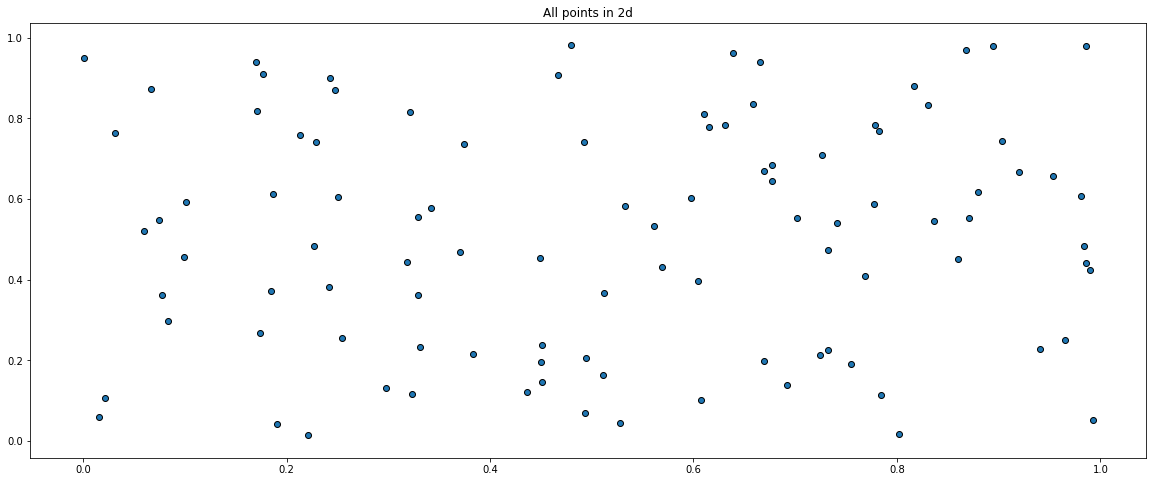

In [9]:
import numpy as np

a = -1
b = 1
n = 100

# all points
X = np.random.uniform(0, 1, (n, 2))
plt.title('All points in 2d')

plt.scatter(X[:,0], X[:,1], marker='o', edgecolors='k');

In [10]:
# below or above line determines which category they belong to (plus noise)
noise_level = 0.3
noise = noise_level * np.random.normal(0, 1, n)
y = X[:, 1] > a*X[:, 0]+b + noise
y = y.astype(int)
y

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

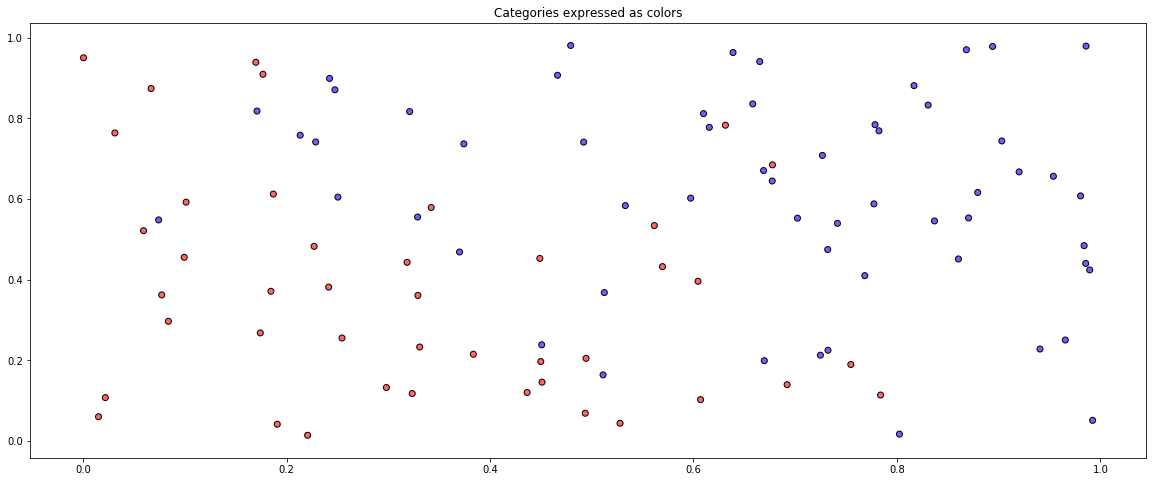

In [11]:
from matplotlib.colors import ListedColormap

plt.title('Categories expressed as colors')
plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(['#FF6666', '#6666FF']), marker='o', edgecolors='k');

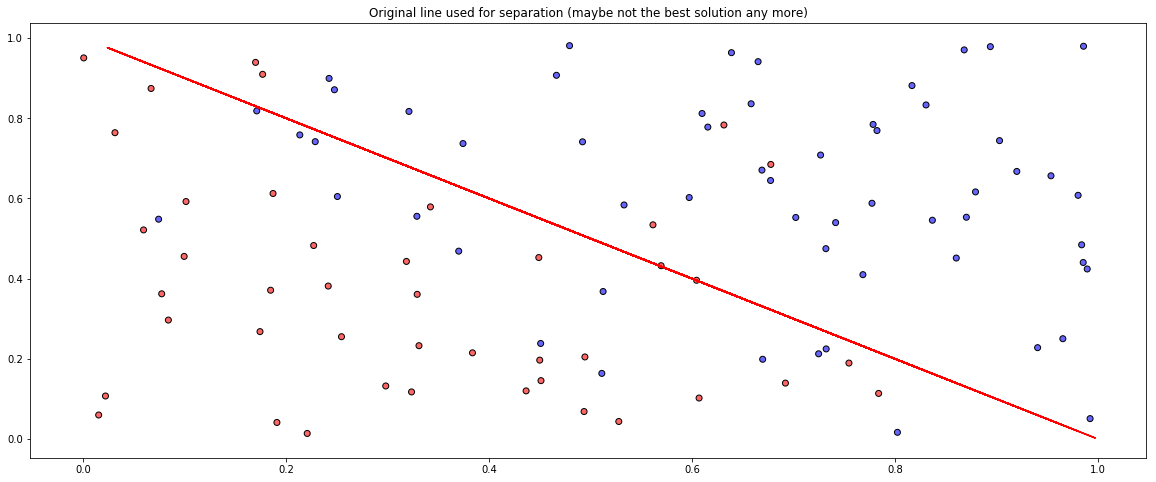

In [12]:
# the exact same line as used for separation, but without noise
line_x = np.random.uniform(0, 1, n)
line_y = a*line_x+b
plt.plot(line_x, line_y, 'r')

plt.title('Original line used for separation (maybe not the best solution any more)')
plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(['#FF6666', '#6666FF']), marker='o', edgecolors='k');

## Understandinging the effect of activation functions


Typically, the output of a neuron is transformed using an activation function which compresses the output to a value between 0 and 1 (sigmoid), or between -1 and 1 (tanh) or sets all negative values to zero (relu).

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/neuron.jpg'>

### Typical Activation Functions

<img src='https://djcordhose.github.io/ai/img/activation-functions.jpg'>


In [13]:
from tensorflow.keras.layers import Layer

# we derive from a TensorFlow Layer
class LinearLayer(Layer):
  """y = w.x + b"""

  # initializing our layer
  def __init__(self, units=1, input_dim=1):
      super(LinearLayer, self).__init__()
      # these are our weights, which can be learned, initialized normally around 0 with stddev of 2
      self.w = tf.Variable(
          initial_value = tf.random_normal_initializer(stddev=2)(shape=(input_dim, units), dtype='float32'),
          trainable=True,
          name='weights')
      # these are our bisases, also can be learned, initialized as 0
      self.b = tf.Variable(
          initial_value = tf.zeros_initializer()(shape=(units,), dtype='float32'),
          trainable=True,
          name='biases')

  # what the layer does (some as in our example before)
  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b
    
# just one neuron and one input (but could be as many as we like)    
linear_layer = LinearLayer()
linear_layer.trainable_variables

[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[-0.5306324]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

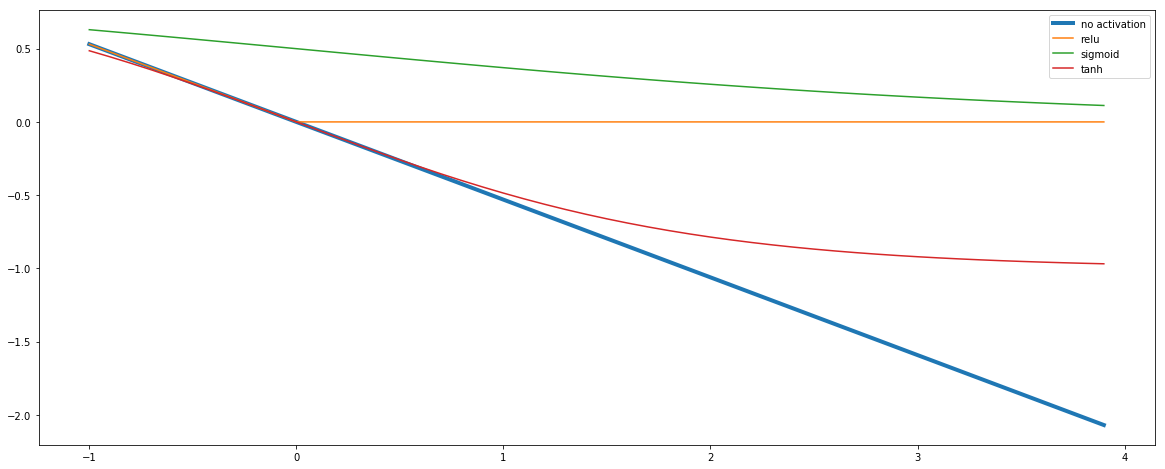

In [14]:
x = tf.reshape(tf.constant(tf.range(-1, 4, 0.1)), (50, 1))
y_pred = linear_layer(x)

plt.plot(x, y_pred, linewidth=4)

y_pred_relu = tf.nn.relu(y_pred)
plt.plot(x, y_pred_relu)

y_pred_sigmoid = tf.nn.sigmoid(y_pred)
plt.plot(x, y_pred_sigmoid)

y_pred_tanh = tf.nn.tanh(y_pred)
plt.plot(x, y_pred_tanh)

plt.legend(['no activation', 'relu', 'sigmoid', 'tanh']);

## Training using so called 'Logictic Regression'

### We compress output between 0 and 1 using sigmoid to match y
* everything below 0.5 counts as 0, everthing above as 1

In [0]:
# sharing initialization from linear layer, but applying sigmoid when called 
class SigmoidLayer(LinearLayer):
  """y = sigmoid(w.x + b)"""

  def __init__(self, **kwargs):
      super(SigmoidLayer, self).__init__(**kwargs)

  def call(self, inputs):
      return tf.sigmoid(super().call(inputs))


### We have 2d input now

In [16]:
x = tf.constant(X, dtype='float32')
y_true = tf.constant(y, dtype='float32')
x.shape

TensorShape([100, 2])

In [0]:
model = SigmoidLayer(input_dim=2)

### Reconsidering the loss function

_cross entropy is an alternative to mean squared error_ 

* cross entropy can be used as an error measure when a network's outputs can be thought of as representing independent hypotheses
* activations can be understood as representing the probability that each hypothesis might be true
* the loss indicates the distance between what the network believes this distribution should be, and what the teacher says it should be 
* in this case we are dealing with two exclusive hypothesis: either a sample is blue or it is red
* this makes this binary cross entropy

https://en.wikipedia.org/wiki/Cross_entropy 

http://www.cse.unsw.edu.au/~billw/cs9444/crossentropy.html

In [0]:
loss_fn = tf.losses.binary_crossentropy

### Advanced Optimizer (pretty much standard)

In [0]:
# standard optimizer using advanced properties
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)

### We also have a new metric: what share of predictions is correct?

In [0]:
# basic metric for classification: share of correctly predicted samples
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/metrics/Accuracy
m = tf.keras.metrics.Accuracy()

### The training loop is pretty much unchanged from regression

In [21]:
EPOCHS = 1000

losses = []
accuracies = []

for step in range(EPOCHS):
  # Open a GradientTape.
  with tf.GradientTape() as tape:

    # Forward pass.
    y_pred = model(x)

    # Loss value for this batch.
    loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))

  y_pred_binary = (tf.squeeze(y_pred) > 0.5).numpy().astype(float)
  m.update_state(tf.squeeze(y_true), y_pred_binary)
  accuracy = m.result()

  losses.append(loss)
  accuracies.append(accuracy)
     
  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, model.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
print(loss)

tf.Tensor(0.37156594, shape=(), dtype=float32)


In [23]:
print(accuracy)

tf.Tensor(0.80075, shape=(), dtype=float32)


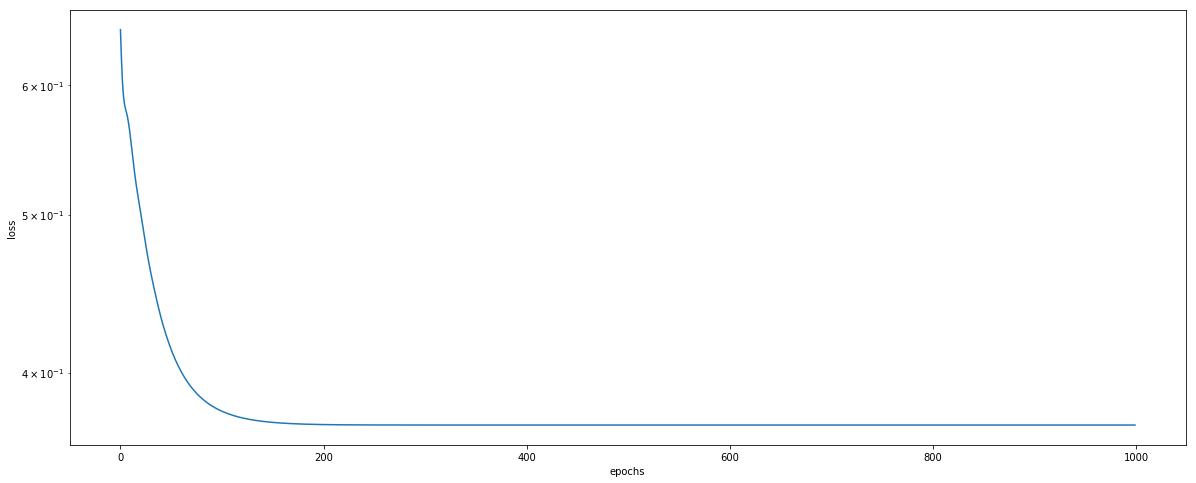

In [24]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(losses);

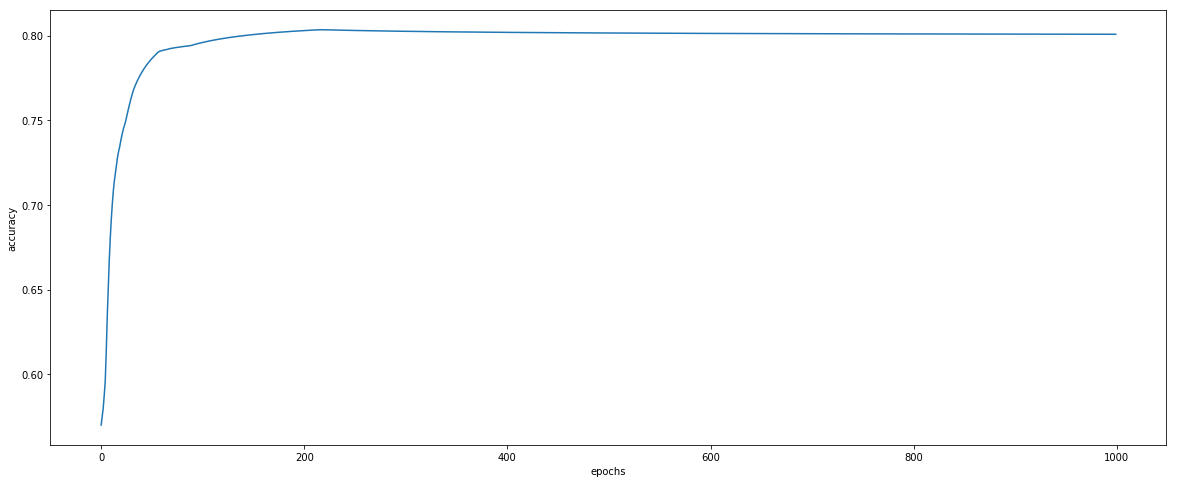

In [25]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(accuracies);

## We are drawing a sigmoid in 3d and turn it into a step

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf2/img/logistic.jpg?raw=1'>

### Predictions so far are just numbers between 0 and 1

In [26]:
# tf.squeeze removes addional 1-dim dimensions
y_pred = tf.squeeze(model(x))
y_pred

<tf.Tensor: id=113347, shape=(100,), dtype=float32, numpy=
array([0.9879731 , 0.22374871, 0.97968644, 0.6390078 , 0.9892489 ,
       0.911252  , 0.96857667, 0.93598986, 0.9199346 , 0.44595447,
       0.04667822, 0.9146045 , 0.07296181, 0.8616978 , 0.5957711 ,
       0.07378116, 0.97607255, 0.17967466, 0.12418878, 0.6217059 ,
       0.6462048 , 0.6193728 , 0.09743789, 0.02967137, 0.14096013,
       0.93428457, 0.0532676 , 0.05836904, 0.3643642 , 0.35268477,
       0.98056364, 0.46076572, 0.8721446 , 0.08319283, 0.9982297 ,
       0.7547329 , 0.07803726, 0.25010678, 0.1476962 , 0.1887672 ,
       0.49722043, 0.9455801 , 0.46891922, 0.13560826, 0.5086933 ,
       0.46322858, 0.9125289 , 0.978583  , 0.9650792 , 0.9380867 ,
       0.03965983, 0.24186912, 0.24786332, 0.01735809, 0.12039125,
       0.9793314 , 0.5921884 , 0.8865149 , 0.97548765, 0.0072892 ,
       0.00542998, 0.39344022, 0.9443357 , 0.2003682 , 0.9457315 ,
       0.81430125, 0.6401677 , 0.74245864, 0.13390845, 0.84080184,
   

### for now everything below 0.5 counts as 0, everthing above as 1
effectively turning this into a step


In [27]:
y_pred_binary = (y_pred > 0.5).numpy().astype(float)
y_pred_binary

array([1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0.])

In [28]:
misclassified = y_true - y_pred_binary
misclassified

<tf.Tensor: id=113351, shape=(100,), dtype=float32, numpy=
array([ 0.,  1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0., -1.,
        0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.], dtype=float32)>

### Strong colors indicate misclassification

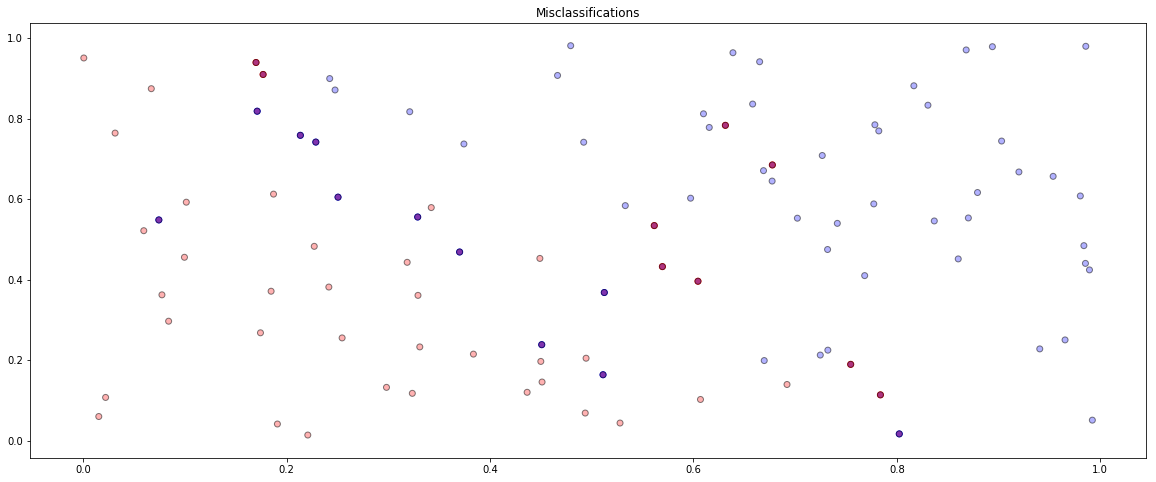

In [29]:
plt.scatter(X[:,0], X[:,1], c=misclassified, cmap=ListedColormap(['#FF0000', '#FFFFFF', '#0000FF']), marker='o')
plt.scatter(X[:,0], X[:,1], c=y_pred_binary, cmap=ListedColormap(['#FF6666', '#6666FF']), marker='o', edgecolors='k', alpha=0.5)
plt.title('Misclassifications');

### Let's have a look at the sigmoid in 3d

In [0]:
# for interactive 3d on local jupyer notebook
# will make figure disappear on Colab

# %matplotlib notebook

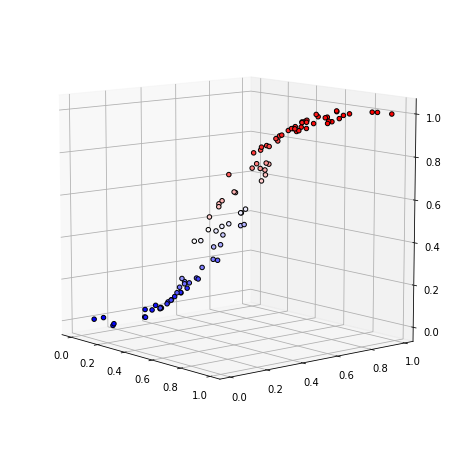

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

# we can have the probability encoded in shade of color
# ax.scatter(X[:, 0], X[:, 1], y_pred, c=y_pred_binary, 
ax.scatter(X[:, 0], X[:, 1], y_pred, c=y_pred, 
#            https://matplotlib.org/3.1.0/gallery/color/colormap_reference.html
           cmap=plt.cm.bwr,
           depthshade=False,
           marker='o', edgecolors='k')

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(elev=10, azim=-40)


### And now the step

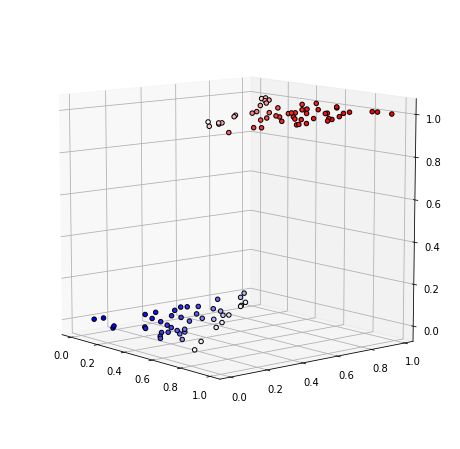

In [32]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y_pred_binary, c=y_pred, 
           cmap=plt.cm.bwr,
           depthshade=False,
           marker='o', edgecolors='k')

ax.view_init(elev=10, azim=-40)

### Exercise: run this classification experiment with a bit more noise

* generated your own dataset using a bit more noise
* train the model and generate all the plots
* does all this make sense to you?

## The same solution using high level Keas API

In [33]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential([
  Dense(units=1, input_dim=2, activation='sigmoid')                   
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [34]:
%%time 

model.compile(loss=loss_fn, # binary cross entropy, unchanged from low level example
             optimizer=optimizer, # adam, unchanged from low level example
             metrics=['accuracy'])

# does a similar thing internally as our loop from above
history = model.fit(x, y_true, epochs=EPOCHS, verbose=0)

CPU times: user 19.6 s, sys: 2.04 s, total: 21.6 s
Wall time: 15.7 s


In [35]:
loss, accuracy = model.evaluate(x, y_true, verbose=0)
loss, accuracy

(0.37163572549819945, 0.8)

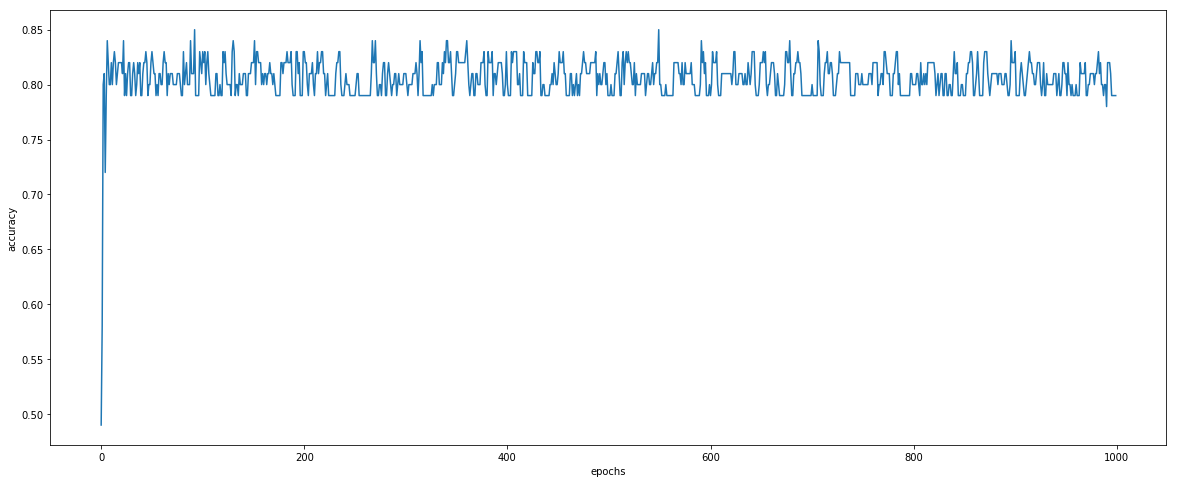

In [36]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])

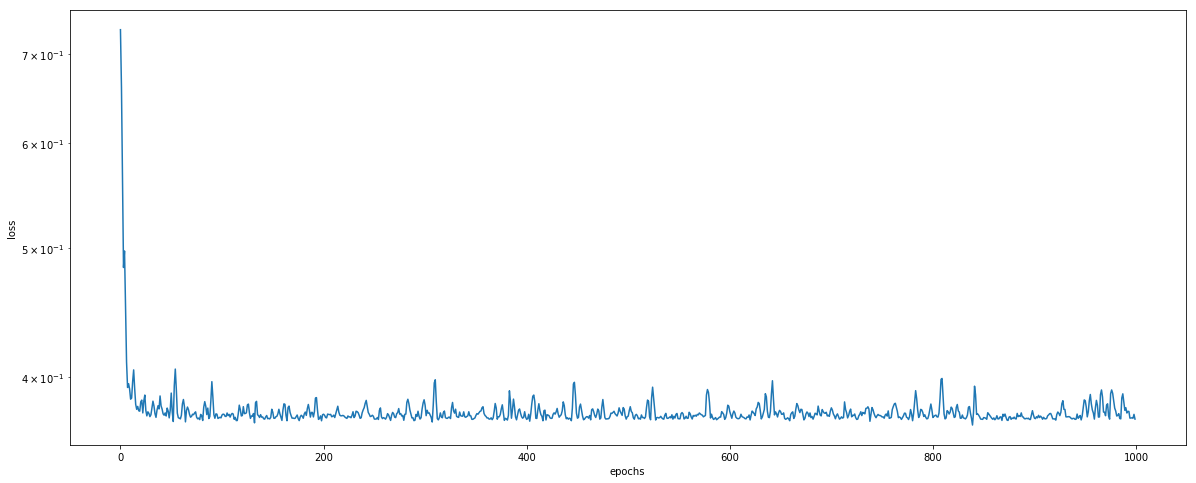

In [37]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])

In [38]:
y_pred = model.predict(x)
y_pred_binary = (tf.squeeze(y_pred) > 0.5).numpy().astype(float)
y_pred_binary

array([1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0.])

## From single neuron to network in the TensorFlow Playground

<img src='https://djcordhose.github.io/ai/img/tf-plaground.png'>

https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.98437&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

## Bonus I: Basic Metrics

* https://en.wikipedia.org/wiki/Precision_and_recall
* https://en.wikipedia.org/wiki/F1_score

### Most typical metrics

* _Precision_: ability not to label a sample as positive (1) that is negative (0)

* _Recall_: ability to find all the positive (1) samples

* _F1-Score_
  * harmonic mean of the precision and recall
  * harmonic mean is a good mean for ratios
  * best value at 1 and worstat 0

* _Support_: number of occurrences of samples for each class


In [39]:
# TensorFlow: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/metrics
# Scikit-learn: https://scikit-learn.org/stable/modules/model_evaluation.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred_binary)
precision, recall, f1_score, support

(array([0.75555556, 0.83636364]),
 array([0.79069767, 0.80701754]),
 array([0.77272727, 0.82142857]),
 array([43, 57]))

## Bouns II: How would the scores change if we changed the threshold?

### ROC and AUC

_graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied_

_ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better._

* https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
* https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc


In [40]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
# https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics

from sklearn.metrics import roc_curve, auc
# roc_curve?
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.02325581, 0.02325581,
        0.04651163, 0.04651163, 0.06976744, 0.06976744, 0.09302326,
        0.09302326, 0.13953488, 0.13953488, 0.20930233, 0.20930233,
        0.25581395, 0.25581395, 0.27906977, 0.27906977, 0.30232558,
        0.30232558, 0.3255814 , 0.3255814 , 0.41860465, 0.41860465,
        0.69767442, 0.69767442, 1.        ]),
 array([0.        , 0.01754386, 0.38596491, 0.38596491, 0.45614035,
        0.45614035, 0.68421053, 0.68421053, 0.75438596, 0.75438596,
        0.77192982, 0.77192982, 0.78947368, 0.78947368, 0.8245614 ,
        0.8245614 , 0.89473684, 0.89473684, 0.9122807 , 0.9122807 ,
        0.92982456, 0.92982456, 0.94736842, 0.94736842, 0.98245614,
        0.98245614, 1.        , 1.        ]),
 array([1.9982458 , 0.99824584, 0.94478846, 0.9447228 , 0.9360789 ,
        0.93349415, 0.7504105 , 0.73843354, 0.6518281 , 0.64750594,
        0.64453125, 0.6355406 , 0.61752605, 0.58351547, 0.4968578 ,
        0.45601773, 0.44

In [41]:
roc_auc = auc(fpr, tpr)
roc_auc

0.9106487148102814

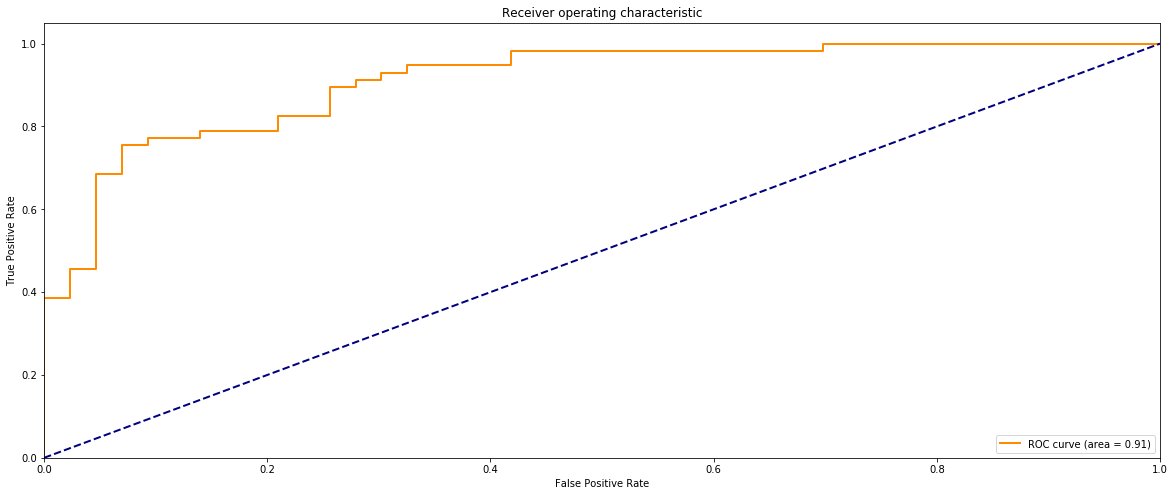

In [42]:
# code more or less taken from
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right");